In [1]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import h5py
import pickle
import pandas
import matplotlib.pyplot as plt
#import deepdish.io as io
#import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from keras.models import Model,Sequential
#from keras.layers import Input, Dense, Dropout, Layer
#from keras.utils import plot_model
#from keras.models import load_model
from sklearn.preprocessing import scale, normalize
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
import random
from pca_plotter import PCAPlotter
from sklearn.metrics import roc_auc_score, roc_curve
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
class Tripletnet(keras.Model):
    def __init__(self, embeddingnet):
        super(Tripletnet, self).__init__()
        self.embeddingnet = embeddingnet

    def call(self, x, y, z):
        #print("x: ",x)
        #print("y: ",y)
        #print("z: ",z)
        latent_x,mean_x,logvar_x = self.embeddingnet(x)
        latent_y,mean_y,logvar_y = self.embeddingnet(y)
        latent_z,mean_z,logvar_z = self.embeddingnet(z)
        dist_a = tf.reduce_mean(tf.square(mean_x - mean_y), axis=1)
        dist_b = tf.reduce_mean(tf.square(mean_x - mean_z), axis=1)
        return latent_x,mean_x,logvar_x,\
            latent_y,mean_y,logvar_y,\
            latent_z,mean_z,logvar_z,\
            dist_a, dist_b


In [3]:
def sampling(args):
    mu, sigma = args
    batch     = tf.shape(mu)[0]
    dim       = tf.shape(mu)[1]
    eps       = tf.keras.backend.random_normal(shape=(batch, dim))
    return mu + tf.exp(sigma / 2) * eps

In [4]:
input_dim = 80
encoding_dim = 10
inputs = keras.Input((None, input_dim))

class _Encoder(keras.Model):
    def __init__(self, **kwargs):
        super(_Encoder, self).__init__(**kwargs)
        #self.input_dim = input_dim
        #self.encoding_dim = encoding_dim
        #self.Input = keras.Input((None, self.input_dim))
        self.layer_1 = layers.Dense(256, activation="relu")
        self.layer_2 = layers.Dense(128, activation="relu")
        self.layer_3 = layers.Dense(64, activation="relu")
    
    def call(self,inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        self.mean = layers.Dense(encoding_dim, name="z_mean")(x)
        self.log_var = layers.Dense(encoding_dim, name="z_log_var")(x)
        self.z = layers.Lambda(sampling, output_shape=(encoding_dim,), name='z')([self.mean, self.log_var])
        return self.z, self.mean, self.log_var

In [5]:
class _Decoder(keras.Model):
    def __init__(self):
        super(_Decoder, self).__init__()
        #self.encoding_dim = encoding_dim
        #self.Input = keras.Input(shape=(self.encoding_dim,), name='z_sampling')
        #self.layer_1 = layers.Dense(64, activation="relu")
        self.layer_1 = layers.Dense(128, activation="relu")
        self.layer_2 = layers.Dense(256, activation="relu")
        self.layer_3 = layers.Dense(80, activation="sigmoid")
        
    def call(self,inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        output = self.layer_3(x)
        return output

In [15]:
def kl_reconstruction_loss(x, recon_x, mu, log_var):
    reco_loss = tf.reduce_sum(tf.pow(x - recon_x,2))/80
    kl_loss = 1 + log_var - tf.square(mu) - tf.exp(log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis= -1)
    kl_loss *= -0.5
    return tf.reduce_mean(reco_loss + kl_loss)

In [7]:
def create_batch(batch_size=256):
    x_anchors = np.zeros((batch_size, 80))
    x_positives = np.zeros((batch_size, 80))
    x_negatives = np.zeros((batch_size, 80))
    
    for i in range(0,batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.choice(bkg_index)
        x_anchor = x_train[random_index]
        y = y_train[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

In [8]:
# Data loading part
# Loading QCD sample to use jet_pT for pT scaling
fqcd=h5py.File('/home/zp/gupta/jetAnomaly/utils/qcd_pt_scaled.h5','r')
qcd_train_bkg = fqcd['table']
qcd_train_bkg=qcd_train_bkg[:,:80]
qcd_train = qcd_train_bkg[0:200000]
print ("qcd_train: ",qcd_train.shape)

# Loading zboson sample to use jet_pT for pT scaling
fzboson=h5py.File('/lcg/storage13/atlas/gupta/stealth_boson/Zp2200_S80A15_pt_scaled.h5','r')
zboson_pt_scaled = fzboson['table']
zboson_pt_scaled = zboson_pt_scaled[:,:80]
print ("zboson_pt_scaled.shape: ",zboson_pt_scaled.shape)

# Loading ttbar sample to use jet_pT for pT scaling
fttbar=h5py.File('/home/zp/gupta/jetAnomaly/utils/ttbar_pt_scaled.h5','r')
ttbar_pt_scaled = fttbar['table']
ttbar_pt_scaled = ttbar_pt_scaled[:,:80]
print ("ttbar_pt_scaled: ",ttbar_pt_scaled.shape)

qcd_train:  (200000, 80)
zboson_pt_scaled.shape:  (97579, 80)
ttbar_pt_scaled:  (320124, 80)


In [9]:
# mixing qcd and z_boson for training
qcd_zboson_mixed = np.concatenate((qcd_train, zboson_pt_scaled), axis=0)
y_qcd_zboson = np.concatenate((np.zeros(len(qcd_train)), np.ones(len(zboson_pt_scaled))), axis=0)
rng = check_random_state(1)
indices = rng.permutation(len(qcd_zboson_mixed))
x_train = np.array([qcd_zboson_mixed[j] for j in indices[:297000]])
y_train = np.array([y_qcd_zboson[j] for j in indices[:297000]])
print("x_train: ",x_train.shape)
print("y_train: ",y_train.shape)

x_train:  (297000, 80)
y_train:  (297000,)


In [10]:
# mixing qcd and tt_bar for test
qcd_test_bkg = qcd_train_bkg[200000:300000]
ttbar_test = ttbar_pt_scaled[0:50000]
qcd_ttbar_mixed = np.concatenate((qcd_test_bkg, ttbar_test), axis=0)
y_qcd_ttbar = np.concatenate((np.zeros(len(qcd_test_bkg)), np.ones(len(ttbar_test))), axis=0)
rng = check_random_state(1)
indices_1 = rng.permutation(len(qcd_ttbar_mixed))
x_test = qcd_ttbar_mixed[indices_1]
y_test = y_qcd_ttbar[indices_1]
print("x_test: ",x_test.shape)
print("y_test: ",y_test.shape)

x_test:  (150000, 80)
y_test:  (150000,)


In [11]:
# Scaling datasets
scaler = RobustScaler().fit(x_train)
x_train_scaled=scaler.transform(x_train)
x_test_scaled=scaler.transform(x_test)
bkg_index = np.where(y_train == 0)[0]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_scaled,y_train))
train_dataset = train_dataset.batch(4096)

In [ ]:
alpha = 0.2

epoch_losses = []
num_epochs = 1
encoder= _Encoder()
decoder = _Decoder()
tnet = Tripletnet(encoder)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
for epoch in range (num_epochs):
    batch_losses = []
    step = 0
    print("epoch: ", epoch)
    for x,y in train_dataset:
        step = step+1
        print("step: ",step)
        batch_size=x.shape[0]
        anchor,positive,negative = create_batch(batch_size)
        #encoder= _Encoder()
        #tnet = Tripletnet(encoder)
        batch_loss=0
        with tf.GradientTape() as tape:
            for idx in range (batch_size):
                #print("idx: ", idx)
            #with tf.GradientTape() as tape:
                latent_ach,mean_ach,logvar_ach,\
                latent_p,mean_p,logvar_p,\
                latent_n,mean_n,logvar_n,dp,dn = tnet(\
                                                  anchor[idx,:].reshape((1,80)),\
                                                   positive[idx,:].reshape((1,80)),\
                                                   negative[idx,:].reshape((1,80)))
            #get reconstructed images
                reconstructed_ach = decoder(latent_ach)
                reconstructed_p = decoder(latent_p)
            #reconstructed_n = decoder(latent_n)
                loss_vae = kl_reconstruction_loss(anchor[idx],reconstructed_ach,mean_ach,logvar_ach)
                loss_vae += kl_reconstruction_loss(positive[idx],reconstructed_p,mean_p,logvar_p)
            #loss_vae += kl_reconstruction_loss(negative,reconstructed_n,mean_n,logvar_n)
                loss_vae = loss_vae/2
                loss_triplet = float(tf.maximum(dp - dn + alpha, 0.))
                loss = loss_vae + loss_triplet
            #print("Loss: ", loss)
                batch_loss=batch_loss+loss
                #print("Loss: ", batch_loss)
            batch_loss=batch_loss/batch_size
            print("BatchLoss: ", batch_loss)
            total_trainable_variables = encoder.trainable_variables+decoder.trainable_variables
        #with tf.GradientTape() as tape:
        grads = tape.gradient(batch_loss,total_trainable_variables)
        #print("grads:",grads)
        batch_losses.append(batch_loss)
        optimizer.apply_gradients(zip(grads,total_trainable_variables))
    epoch_losses.append(np.mean(batch_losses))    
    print("epoch: ",epoch)
    print("loss: ",epoch_losses[epoch])
        
        

epoch:  0
step:  1

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor

In [36]:
encoder = _Encoder()
z, mean, var = encoder(tf.random.uniform([1,80]))
#decoder.summary()
#encoder.trainable_variables

In [39]:
len(encoder.trainable_variables+encoder.trainable_variables)

12

In [30]:
tnet = Tripletnet(encoder)

In [31]:
_,_,_,_,_,_,_,_,_,dp,dn = tnet(tf.random.uniform([1,80]),tf.random.uniform([1,80]),tf.random.uniform([1,80]))

x:  tf.Tensor(
[[0.47968566 0.8685161  0.20535028 0.6449919  0.3137709  0.0355078
  0.81877327 0.32247186 0.16846299 0.37724316 0.98070943 0.8950027
  0.97280204 0.89592063 0.619872   0.19825506 0.8513619  0.2199322
  0.6050823  0.03683317 0.65182185 0.21700573 0.13112211 0.5535033
  0.9302949  0.61054885 0.8319149  0.6418209  0.73408437 0.7017555
  0.80665326 0.76897967 0.19125712 0.8082844  0.2850275  0.39690197
  0.8053887  0.9291786  0.66929877 0.6776484  0.495692   0.3982854
  0.6780145  0.44304347 0.49872398 0.2152468  0.91120946 0.73842585
  0.8819351  0.00273609 0.08374417 0.47193253 0.5077473  0.09605086
  0.39067817 0.8858328  0.1313597  0.51842296 0.6573427  0.17632055
  0.4092101  0.09171724 0.6594218  0.7447177  0.89163053 0.82151496
  0.25391662 0.9527339  0.49785638 0.8831736  0.2391988  0.5145031
  0.7945448  0.11219442 0.7497206  0.661505   0.41400743 0.81654084
  0.9121282  0.26904356]], shape=(1, 80), dtype=float32)
y:  tf.Tensor(
[[0.48911035 0.42051756 0.05318868 0

In [25]:
#float(dn)
dn

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.10372391], dtype=float32)>

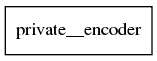

In [10]:
dot_img_file = './model_1.png'
tf.keras.utils.plot_model(encoder,to_file=dot_img_file, show_shapes=True, show_layer_names= True)